In [2]:
from collections import Counter, defaultdict
from pprint import pprint

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set()
except:
    sns = None

In [2]:
!mkdir data
!cd data

!curl -JLO http://fb.me/semanticparsingdialog
!unzip semanticparsingdialog  # creates top-dataset-semantic-parsing folder

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1555k  100 1555k    0     0  1811k      0 --:--:-- --:--:-- --:--:-- 25.2M
Archive:  semanticparsingdialog
   creating: top-dataset-semantic-parsing/
  inflating: top-dataset-semantic-parsing/versionlog.txt  
  inflating: top-dataset-semantic-parsing/tree.py  
  inflating: top-dataset-semantic-parsing/evaluate.py  
  inflating: top-dataset-semantic-parsing/test.tsv  
  inflating: top-dataset-semantic-parsing/README  
  inflating: top-dataset-semantic-parsing/eval.tsv  
  inflating: top-dataset-semantic-parsing/train.tsv  


In [3]:
PREFIX = '../data/top-dataset-semantic-parsing/'

data = pd.read_table(PREFIX + 'train.tsv', names=['text', 'tokens', 'schema'])
data.head(10)

,text,tokens,schema
0,How long will it take to drive from Chicago to...,How long will it take to drive from Chicago to...,[IN:GET_ESTIMATED_DURATION How long will it ta...
1,Will it take shorter to get to the White House...,Will it take shorter to get to the White House...,[IN:UNSUPPORTED_NAVIGATION Will it take shorte...
2,will I make it to the beach by noon if I leave...,will I make it to the beach by noon if I leave...,[IN:GET_ESTIMATED_ARRIVAL will I make it to [S...
3,When should I leave my house to get to the Ham...,When should I leave my house to get to the Ham...,[IN:GET_ESTIMATED_DEPARTURE When should I leav...
4,I need to know if there's a lot of traffic on ...,I need to know if there 's a lot of traffic on...,[IN:GET_INFO_TRAFFIC I need to know if there '...
5,What is the shortest way home,What is the shortest way home,[IN:GET_DIRECTIONS What is the shortest way [S...
6,how long will it take me to drive to fort collins,how long will it take me to drive to fort collins,[IN:GET_ESTIMATED_DURATION how long will it ta...
7,how long would it take to ride a bus to jeddah...,how long would it take to ride a bus to jeddah...,[IN:GET_ESTIMATED_DURATION how long would it t...
8,Can you tell me what is happening at Liberty S...,Can you tell me what is happening at Liberty S...,[IN:GET_EVENT Can you tell me what is happenin...
9,traffic to Midway Airport,traffic to Midway Airport,[IN:GET_INFO_TRAFFIC traffic to [SL:DESTINATIO...


In [4]:
# We can separate EVENT-related and DIRECTIONS-related intents and slots from the rest of the dataset.

In [5]:
def tokenize(text):
    # TODO: make a faster regex version
    tokenized = ""
    for char in text:
        if char in ["[", "]"]:
            char = " " + char + " "
        if char in [":"]:
            char = char + " "
        tokenized += char
    tokens = tokenized.strip(" ").split(" ")
    tokens = [t for t in tokens if t != ""]
    return tokens


In [6]:
vocab = set({'AMOUNT',
 'ATTENDEE_EVENT',
 'ATTRIBUTE_EVENT',
 'CATEGORY_EVENT',
 'CATEGORY_LOCATION',
 'COMBINE',
 'CONTACT',
 'CONTACT_RELATED',
 'DATE_TIME',
 'DATE_TIME_ARRIVAL',
 'DATE_TIME_DEPARTURE',
 'DESTINATION',
 'GET_CONTACT',
 'GET_DIRECTIONS',
 'GET_DISTANCE',
 'GET_ESTIMATED_ARRIVAL',
 'GET_ESTIMATED_DEPARTURE',
 'GET_ESTIMATED_DURATION',
 'GET_EVENT',
 'GET_EVENT_ATTENDEE',
 'GET_EVENT_ATTENDEE_AMOUNT',
 'GET_EVENT_ORGANIZER',
 'GET_INFO_ROAD_CONDITION',
 'GET_INFO_ROUTE',
 'GET_INFO_TRAFFIC',
 'GET_LOCATION',
 'GET_LOCATION_HOME',
 'GET_LOCATION_HOMETOWN',
 'GET_LOCATION_SCHOOL',
 'GET_LOCATION_WORK',
 'GROUP',
 'IN:',
 'LOCATION',
 'LOCATION_CURRENT',
 'LOCATION_MODIFIER',
 'LOCATION_USER',
 'LOCATION_WORK',
 'METHOD_TRAVEL',
 'NAME_EVENT',
 'NEGATION',
 'OBSTRUCTION',
 'OBSTRUCTION_AVOID',
 'ORDINAL',
 'ORGANIZER_EVENT',
 'PATH',
 'PATH_AVOID',
 'POINT_ON_MAP',
 'ROAD_CONDITION',
 'ROAD_CONDITION_AVOID',
 'SEARCH_RADIUS',
 'SL:',
 'SOURCE',
 'TYPE_RELATION',
 'UNINTELLIGIBLE',
 'UNIT_DISTANCE',
 'UNSUPPORTED',
 'UNSUPPORTED_EVENT',
 'UNSUPPORTED_NAVIGATION',
 'UPDATE_DIRECTIONS',
 'WAYPOINT',
 'WAYPOINT_ADDED',
 'WAYPOINT_AVOID',
 '[',
 ']'})


vocab -= {'[', ']', 'SL:', 'IN:'}

## Frequencies

In [7]:
# to distinguish between slots and intents
extended_vocab = {'SL:' + token for token in vocab}.union({'IN:' + token for token in vocab})

frequencies = Counter()

for schema_str in tqdm(data.schema, total=len(data.schema)):
    for token in extended_vocab:
        if token in schema_str:
            frequencies[token] += 1

vocab = set(frequencies.keys())

In [8]:
vocab

{'IN:COMBINE',
 'IN:GET_CONTACT',
 'IN:GET_DIRECTIONS',
 'IN:GET_DISTANCE',
 'IN:GET_ESTIMATED_ARRIVAL',
 'IN:GET_ESTIMATED_DEPARTURE',
 'IN:GET_ESTIMATED_DURATION',
 'IN:GET_EVENT',
 'IN:GET_EVENT_ATTENDEE',
 'IN:GET_EVENT_ATTENDEE_AMOUNT',
 'IN:GET_EVENT_ORGANIZER',
 'IN:GET_INFO_ROAD_CONDITION',
 'IN:GET_INFO_ROUTE',
 'IN:GET_INFO_TRAFFIC',
 'IN:GET_LOCATION',
 'IN:GET_LOCATION_HOME',
 'IN:GET_LOCATION_HOMETOWN',
 'IN:GET_LOCATION_SCHOOL',
 'IN:GET_LOCATION_WORK',
 'IN:NEGATION',
 'IN:UNINTELLIGIBLE',
 'IN:UNSUPPORTED',
 'IN:UNSUPPORTED_EVENT',
 'IN:UNSUPPORTED_NAVIGATION',
 'IN:UPDATE_DIRECTIONS',
 'SL:AMOUNT',
 'SL:ATTENDEE_EVENT',
 'SL:ATTRIBUTE_EVENT',
 'SL:CATEGORY_EVENT',
 'SL:CATEGORY_LOCATION',
 'SL:COMBINE',
 'SL:CONTACT',
 'SL:CONTACT_RELATED',
 'SL:DATE_TIME',
 'SL:DATE_TIME_ARRIVAL',
 'SL:DATE_TIME_DEPARTURE',
 'SL:DESTINATION',
 'SL:GROUP',
 'SL:LOCATION',
 'SL:LOCATION_CURRENT',
 'SL:LOCATION_MODIFIER',
 'SL:LOCATION_USER',
 'SL:LOCATION_WORK',
 'SL:METHOD_TRAVEL',
 'S

### All

<BarContainer object of 61 artists>

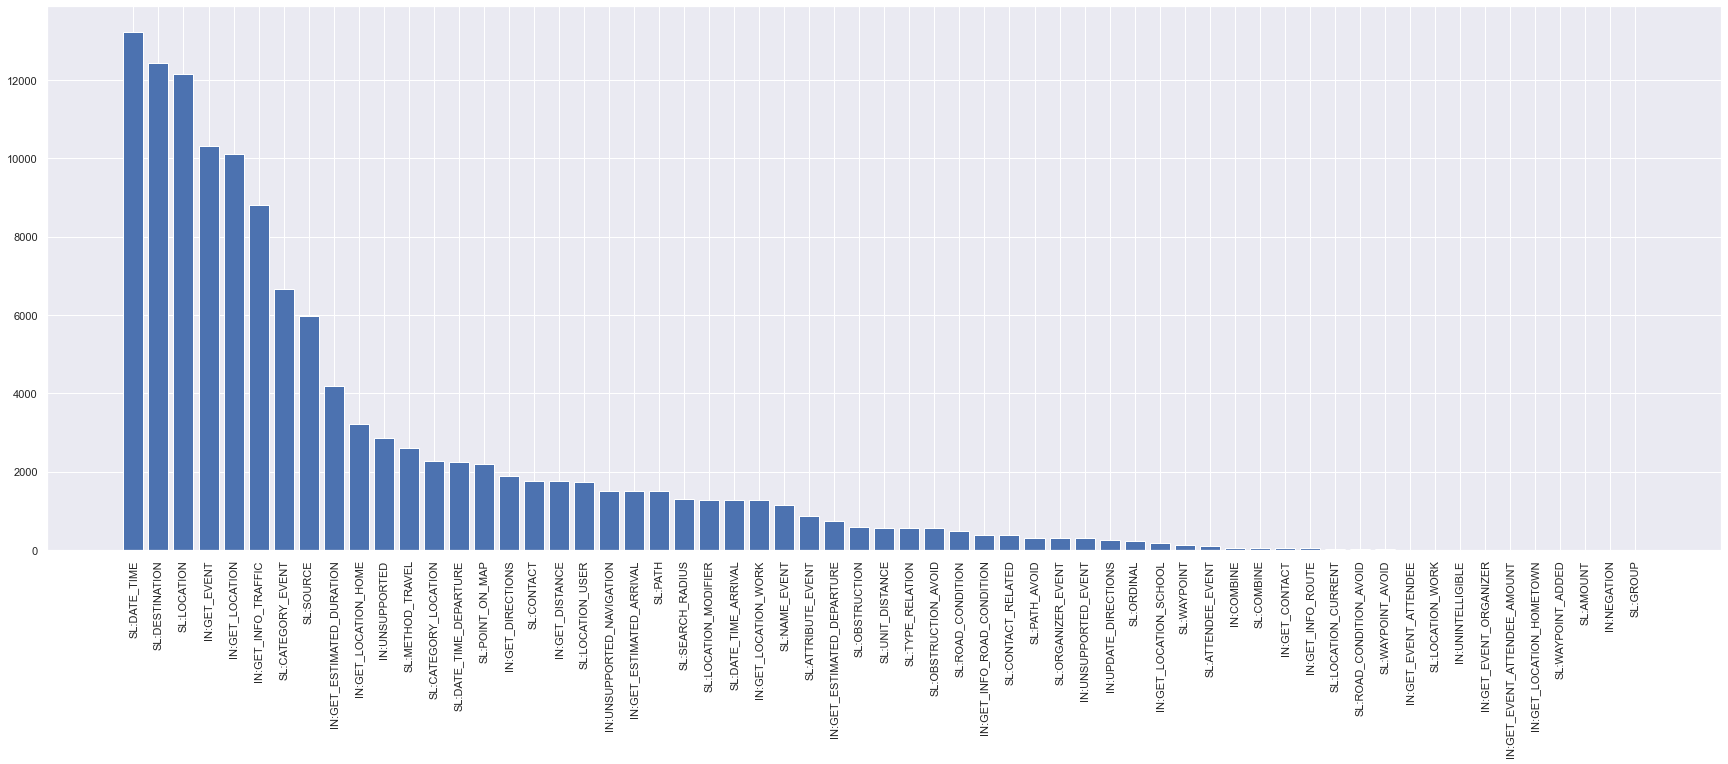

In [9]:
plt.figure(figsize=(30, 10))
labels, values = zip(*frequencies.most_common())
plt.xticks(rotation='vertical')
plt.bar(labels, values)

### Intents

<BarContainer object of 25 artists>

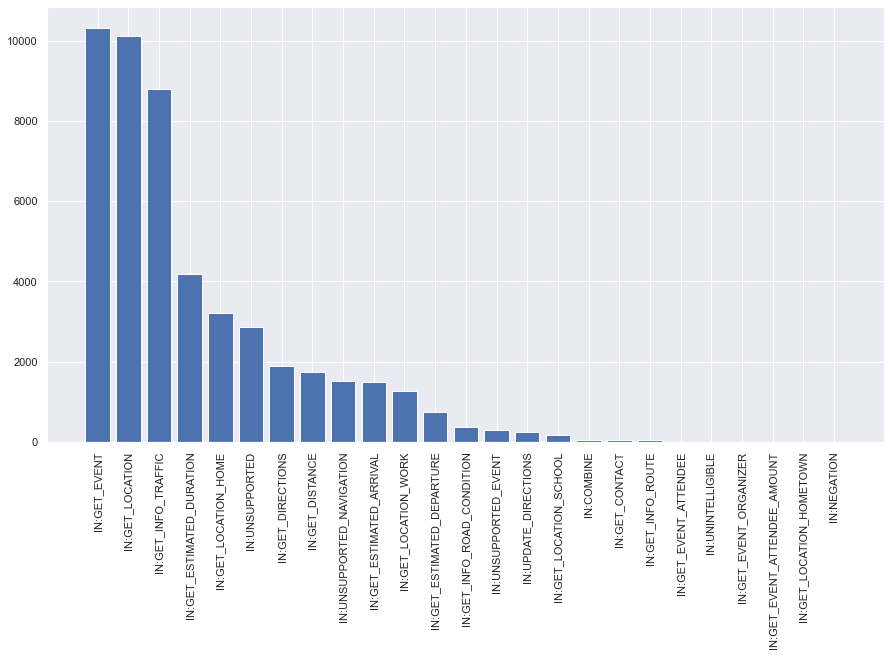

In [10]:
plt.figure(figsize=(15, 8))

freqs = [(x, y) for x, y in frequencies.most_common() if 'IN:' in x]

labels, values = zip(*freqs)
plt.xticks(rotation='vertical')
plt.bar(labels, values)

### Slots (not nested)

<BarContainer object of 36 artists>

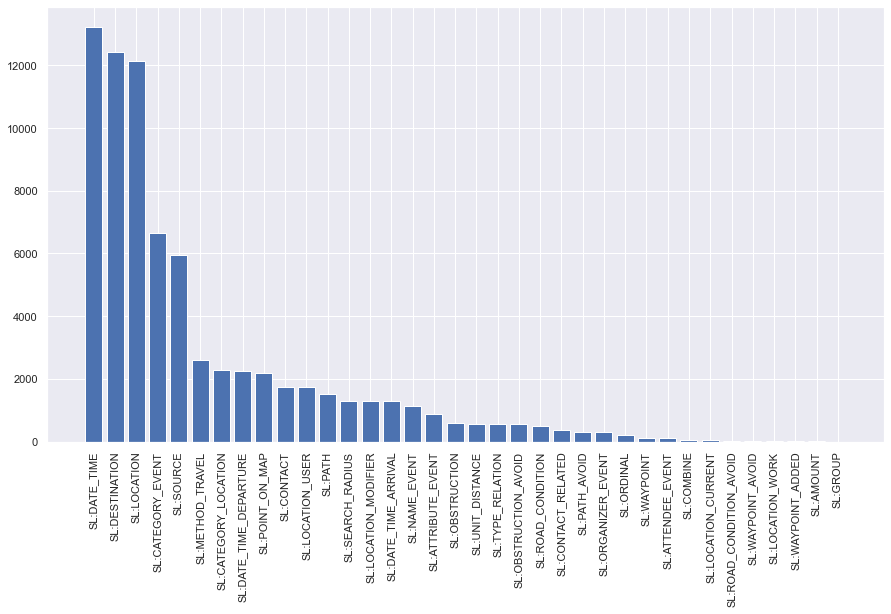

In [11]:
plt.figure(figsize=(15, 8))

freqs = [(x, y) for x, y in frequencies.most_common() if 'SL:' in x]

labels, values = zip(*freqs)
plt.xticks(rotation='vertical')
plt.bar(labels, values)

### Slots (nested)

In [12]:
LBR = '['
RBR = ']'
IN = 'IN:'
SL = 'SL:'

class Tree:
    def __init__(self, entity, subtrees = None):
        self.entity = entity
        self.subtrees = subtrees
        if subtrees is None:
            self.subtrees = []

        self._len = 1

        if len(self.subtrees) > 0:
            self._len += sum(map(len, self.subtrees))

        self._dict_repr = {self.entity: [s._dict_repr for s in self.subtrees]}

    def __repr__(self):
        return repr(self._dict_repr)

    def __eq__(self, other):
        if isinstance(other, dict):
            return self._dict_repr == other
        if isinstance(other, Tree):
            return self._dict_repr == other._dict_repr
        raise ValueError(type(other))
    
    def __len__(self):
        return self._len
    
    @classmethod
    def from_tokens(cls, tokens, return_index=False):
        """Builds a parsing tree for labeled bracketing score computation.

        Args:
            tokens: list of tokens
            return_index: used in recursion to provide toke index

        Returns:
            tuple of size two: Tree, last_index
        """
        # every tree should start with
        # [ ENTITY_TYPE: ENTITY
        if len(tokens) < 3 or tokens[0] != LBR:
            raise ValueError(f'Tree starts with {tokens[:4]}')

        entity_type = tokens[1]

        # ignore invalid subtrees
        if entity_type not in [IN, SL]:
            return None

        entity = entity_type + tokens[2]  # e.g. IN:INTENT

        subtrees = []
        slot_value_tokens = []

        i = 3
        while i < len(tokens):
            token = tokens[i]

            if entity_type == IN and token not in [LBR, RBR]:
                i += 1
                continue

            if token == LBR:
                subtree, j = cls.from_tokens(tokens[i:], return_index=True)
                subtrees.append(subtree)
                i += j
                continue

            if token == RBR:
                if slot_value_tokens:
                    subtrees = [Tree(' '.join(slot_value_tokens))]
                    slot_value_tokens = []
                i += 1
                break

            if entity_type == SL:
                slot_value_tokens.append(token)
                i += 1
                continue

        tree = Tree(entity, subtrees)
                
        if return_index:
            return tree, i

        return tree

In [13]:
test_case_1 = {
    'input': '[ IN:INTENT [ SL:SLOT1 [ SL:SLOT2 slot value ] ] ]',
    'output': Counter(['SLOT1.SLOT2']),
}

test_case_2 = {
    'input': '[ IN:INTENT [ SL:SLOT1 [ SL:SLOT2 slot value ] ] [ SL:SLOT1 [ SL:SLOT2 slot value]]]',
    'output': Counter({'SLOT1.SLOT2': 2}),
}


test_case_3 = {
    'input': ('[ IN:INTENT '
                  '[ IN:GET_SLOT'
                      '[ SL:SLOT1 '
                          '[ SL:SLOT2 slot value ] '
                          '[ SL:SLOT1 [ SL:SLOT2 slot value ] ] '
                          '[ SL:SLOT3 slot3value ]'
                      '] '
                  ']'
              ']'),
    'output': Counter({'SLOT1.SLOT2': 1, 'SLOT1.SLOT1.SLOT2': 1, 'SLOT1.SLOT3': 1}),
}

In [14]:
def get_slot_paths(tree):
    slot_paths = Counter()
    
    for subtree in tree.subtrees:
        is_slot = SL in subtree.entity

        slot_name = subtree.entity[3:]

        slot_subpaths = get_slot_paths(subtree)

        for slot_subname, freq in slot_subpaths.items():
            if is_slot:
                slot_paths[slot_name + '.' + slot_subname] += 1
            else:
                slot_paths[slot_subname] += 1
        
        if len(slot_subpaths) == 0 and is_slot:
            slot_paths[slot_name] += 1

    return slot_paths

In [15]:
for test_case in [test_case_1, test_case_2, test_case_3]:

    counts = get_slot_paths(Tree.from_tokens(tokenize(test_case['input'])))
    assert counts == test_case['output'], (test_case['input'], counts)


In [16]:
# to distinguish between slots and intents
nested_freqs = Counter()

for schema_str in tqdm(data.schema, total=len(data.schema)):
    tree = Tree.from_tokens(tokenize(schema_str))

    nested_slot_counts = get_slot_paths(tree)
    
    nested_freqs += nested_slot_counts

    
for key in list(nested_freqs.keys()):
    if nested_freqs[key] < 3:
        del nested_freqs[key]

only_nested = Counter()

for key, value in nested_freqs.items():
    if '.' in key:
        only_nested[key] = value

In [17]:
len(nested_freqs)

135

In [18]:
nested_freqs.most_common(10)

[('DATE_TIME', 10046),
 ('DESTINATION', 7755),
 ('LOCATION', 7328),
 ('CATEGORY_EVENT', 5258),
 ('SOURCE', 3897),
 ('METHOD_TRAVEL', 2595),
 ('DATE_TIME_DEPARTURE', 2235),
 ('DESTINATION.POINT_ON_MAP', 1320),
 ('DATE_TIME_ARRIVAL', 1273),
 ('DESTINATION.CATEGORY_EVENT', 1222)]

<BarContainer object of 135 artists>

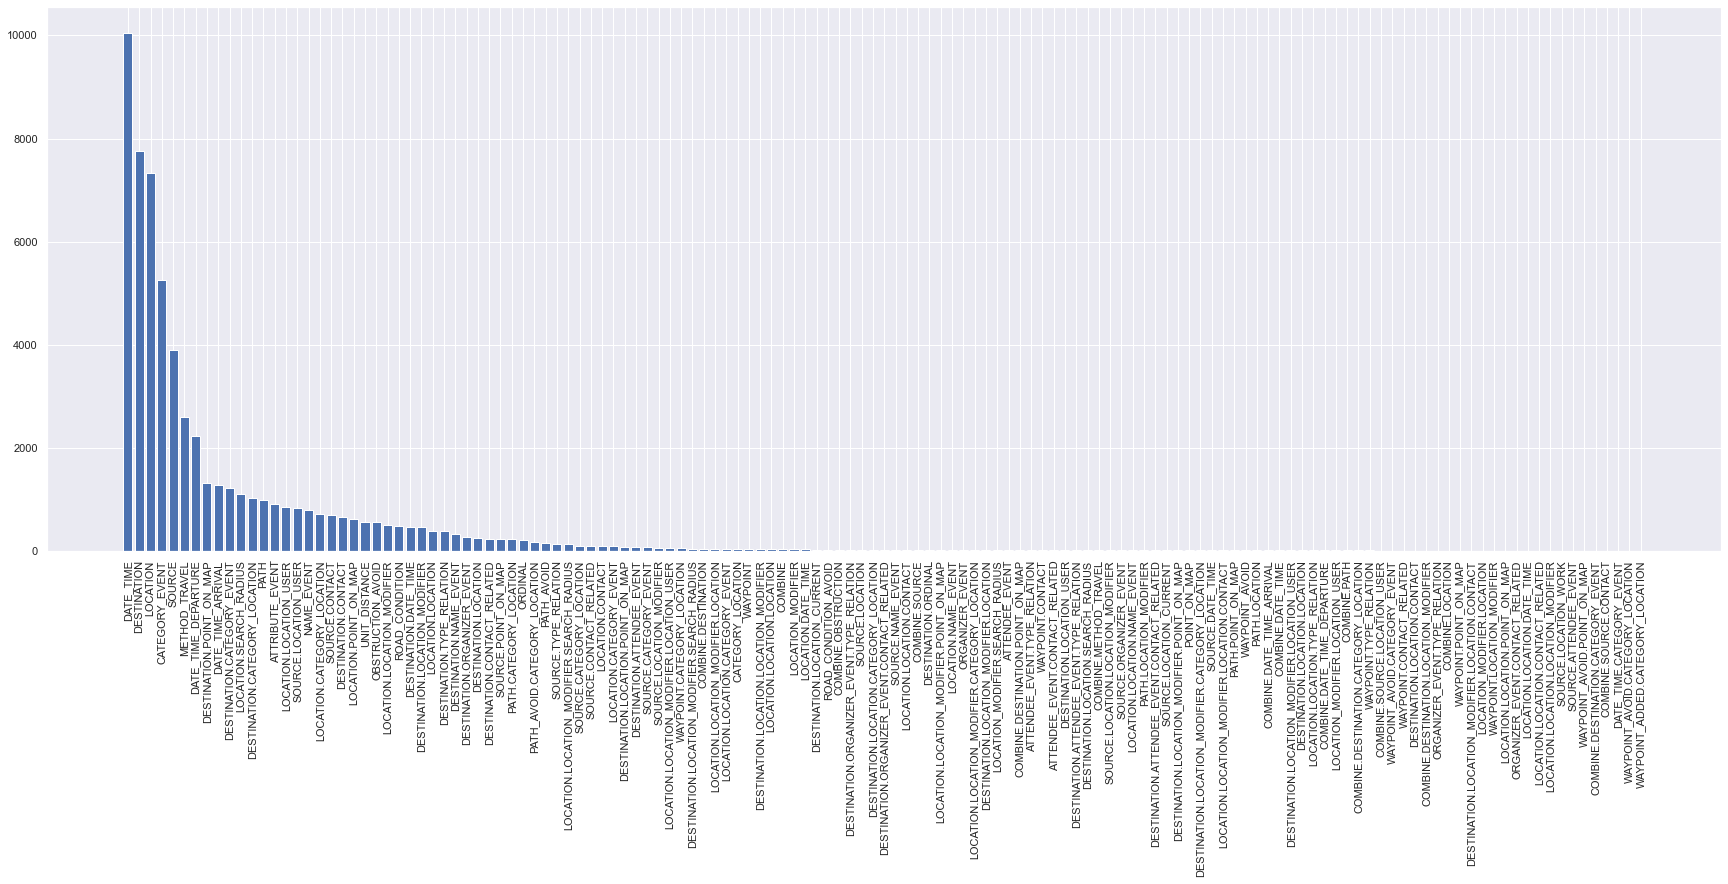

In [19]:
plt.figure(figsize=(30, 10))
labels, values = zip(*nested_freqs.most_common())
plt.xticks(rotation='vertical')
plt.bar(labels, values)

In [20]:
len(only_nested)

110

In [21]:
only_nested.most_common(10)

[('DESTINATION.POINT_ON_MAP', 1320),
 ('DESTINATION.CATEGORY_EVENT', 1222),
 ('LOCATION.SEARCH_RADIUS', 1104),
 ('DESTINATION.CATEGORY_LOCATION', 1019),
 ('LOCATION.LOCATION_USER', 844),
 ('SOURCE.LOCATION_USER', 824),
 ('LOCATION.CATEGORY_LOCATION', 712),
 ('SOURCE.CONTACT', 692),
 ('DESTINATION.CONTACT', 653),
 ('LOCATION.POINT_ON_MAP', 626)]

<BarContainer object of 110 artists>

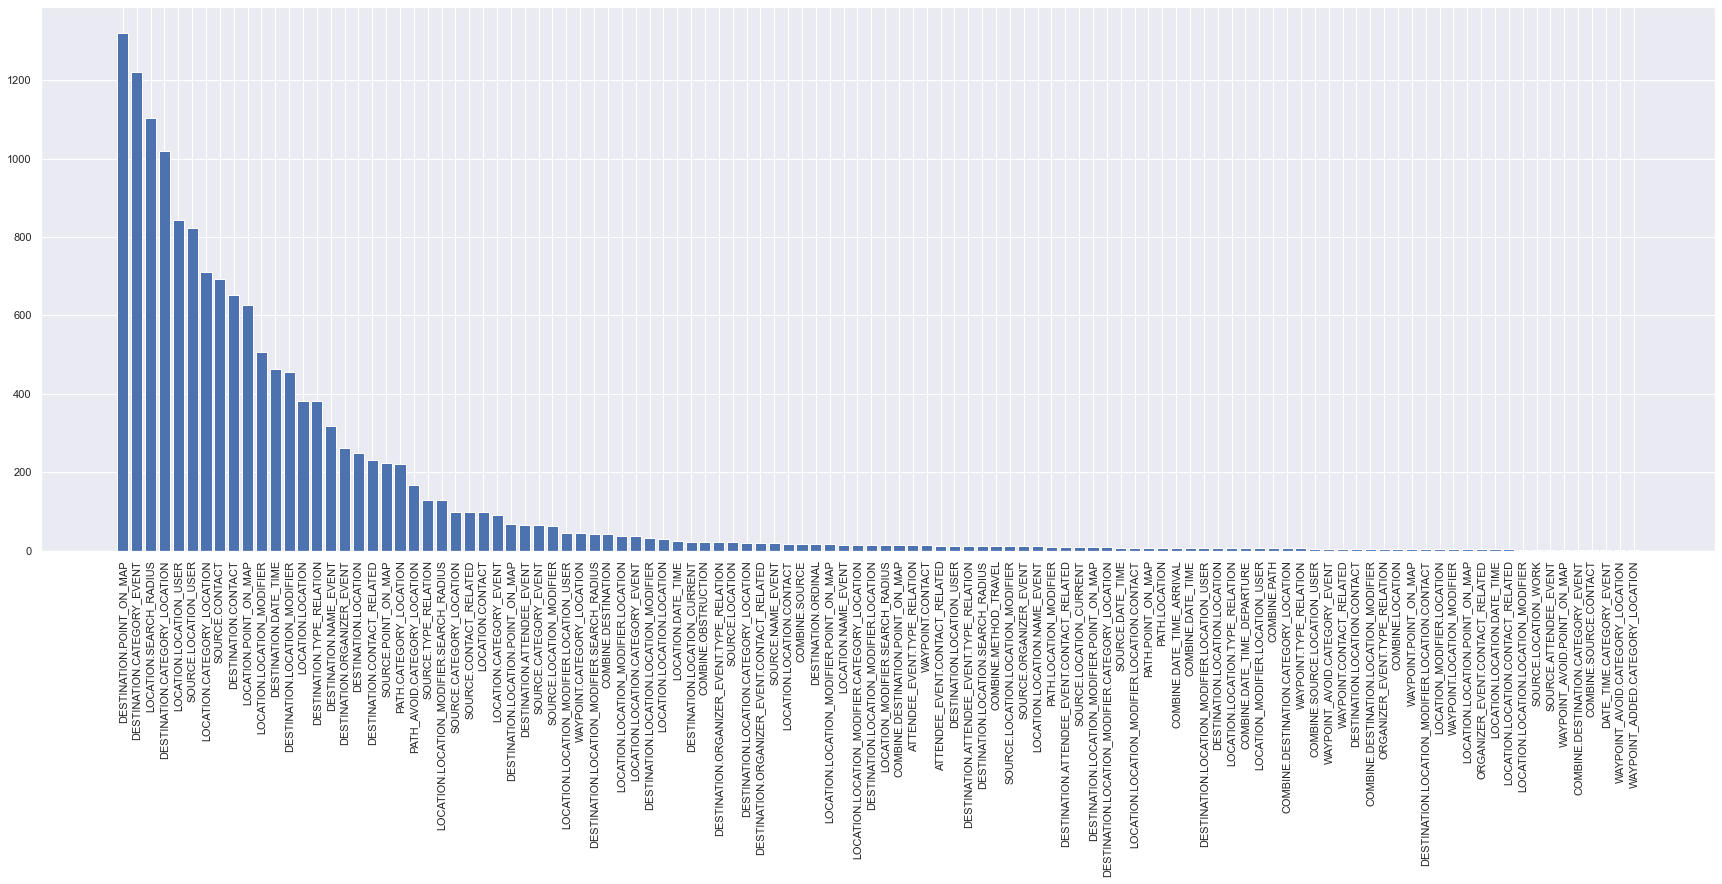

In [22]:
plt.figure(figsize=(30, 10))
labels, values = zip(*only_nested.most_common())
plt.xticks(rotation='vertical')
plt.bar(labels, values)

## Mutual frequencies

In [23]:
mutual_frequencies = Counter()

for schema_str in tqdm(data.schema, total=len(data.schema)):
    for w1 in vocab:
        if w1 not in schema_str:
            continue
        for w2 in vocab - {w1}:
            if w2 not in schema_str:
                continue
#             key = ' - '.join(sorted([w1, w2]))
            key = tuple(sorted([w1, w2]))
            mutual_frequencies[key] += 1

In [24]:
mutual_frequencies.most_common(20)

[(('IN:GET_EVENT', 'SL:DATE_TIME'), 14878),
 (('IN:GET_LOCATION', 'SL:DESTINATION'), 13824),
 (('IN:GET_EVENT', 'SL:CATEGORY_EVENT'), 13304),
 (('IN:GET_EVENT', 'SL:LOCATION'), 13138),
 (('SL:DATE_TIME', 'SL:LOCATION'), 13030),
 (('SL:DESTINATION', 'SL:SOURCE'), 11808),
 (('IN:GET_LOCATION', 'SL:LOCATION'), 9460),
 (('SL:CATEGORY_EVENT', 'SL:DATE_TIME'), 8990),
 (('IN:GET_INFO_TRAFFIC', 'SL:LOCATION'), 8668),
 (('IN:GET_LOCATION', 'SL:DATE_TIME'), 8492),
 (('SL:DATE_TIME', 'SL:DESTINATION'), 8400),
 (('IN:GET_ESTIMATED_DURATION', 'SL:DESTINATION'), 8010),
 (('SL:CATEGORY_EVENT', 'SL:LOCATION'), 7974),
 (('IN:GET_LOCATION', 'IN:GET_LOCATION_HOME'), 6430),
 (('IN:GET_LOCATION_HOME', 'SL:DESTINATION'), 6122),
 (('IN:GET_LOCATION', 'SL:SOURCE'), 5924),
 (('IN:GET_INFO_TRAFFIC', 'SL:DATE_TIME'), 5790),
 (('IN:GET_INFO_TRAFFIC', 'SL:DESTINATION'), 5186),
 (('IN:GET_INFO_TRAFFIC', 'IN:GET_LOCATION'), 5142),
 (('SL:DESTINATION', 'SL:METHOD_TRAVEL'), 5036)]

<BarContainer object of 100 artists>

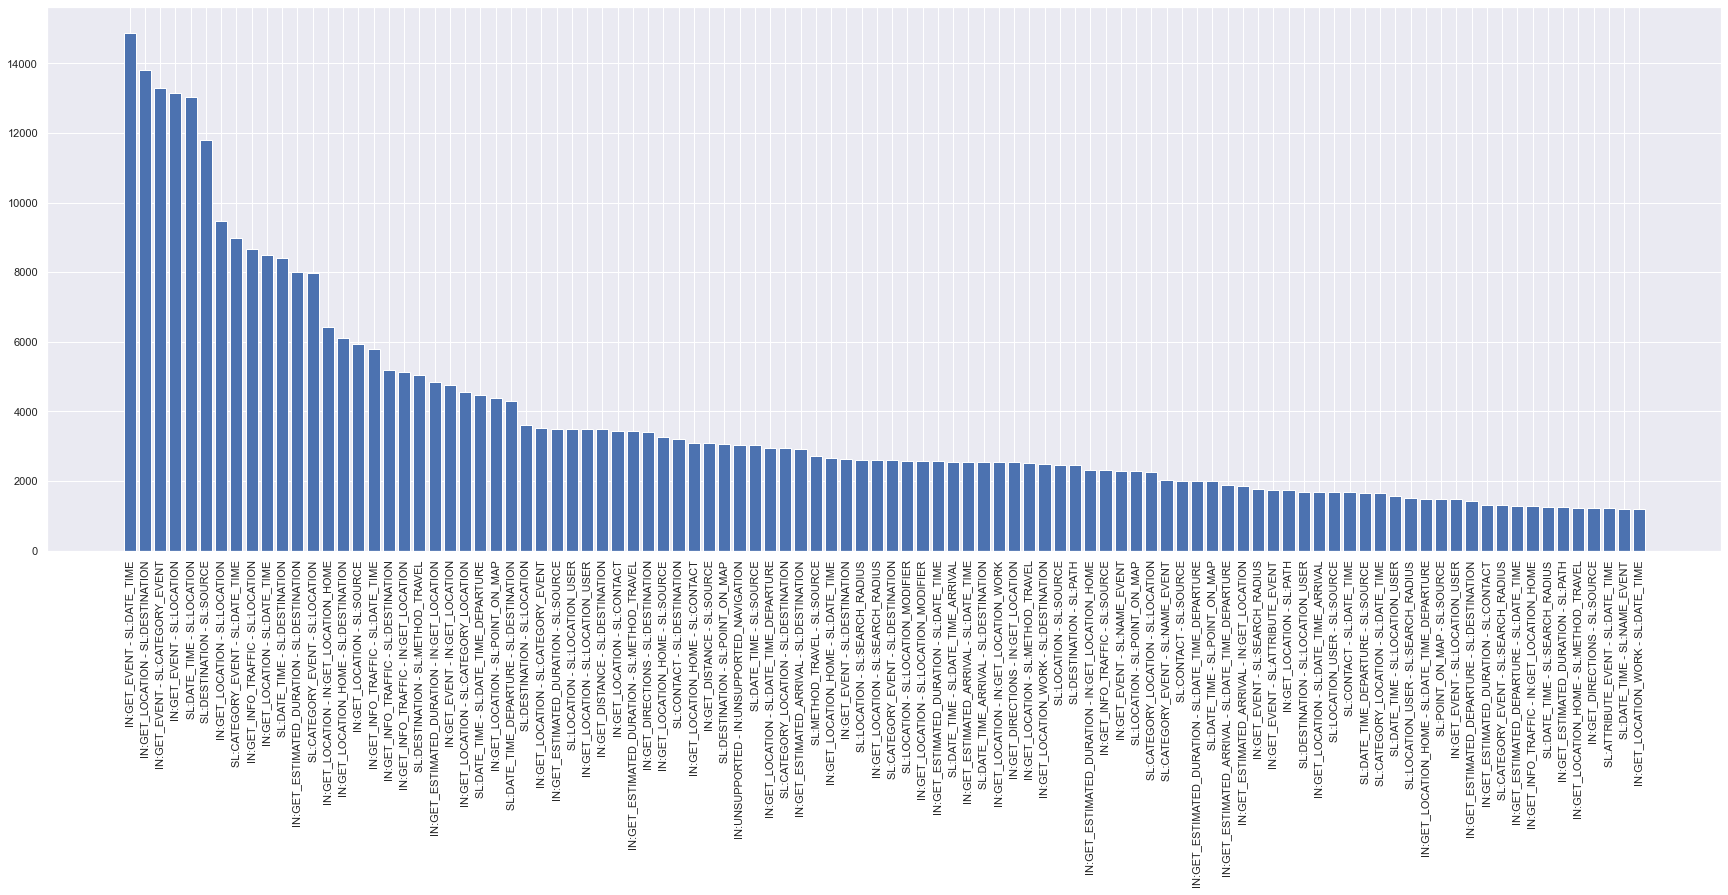

In [25]:
plt.figure(figsize=(30, 10))
labels, values = zip(*mutual_frequencies.most_common(100))

labels = [l1 + ' - ' + l2 for l1, l2 in labels]

plt.xticks(rotation='vertical')
plt.bar(labels, values)

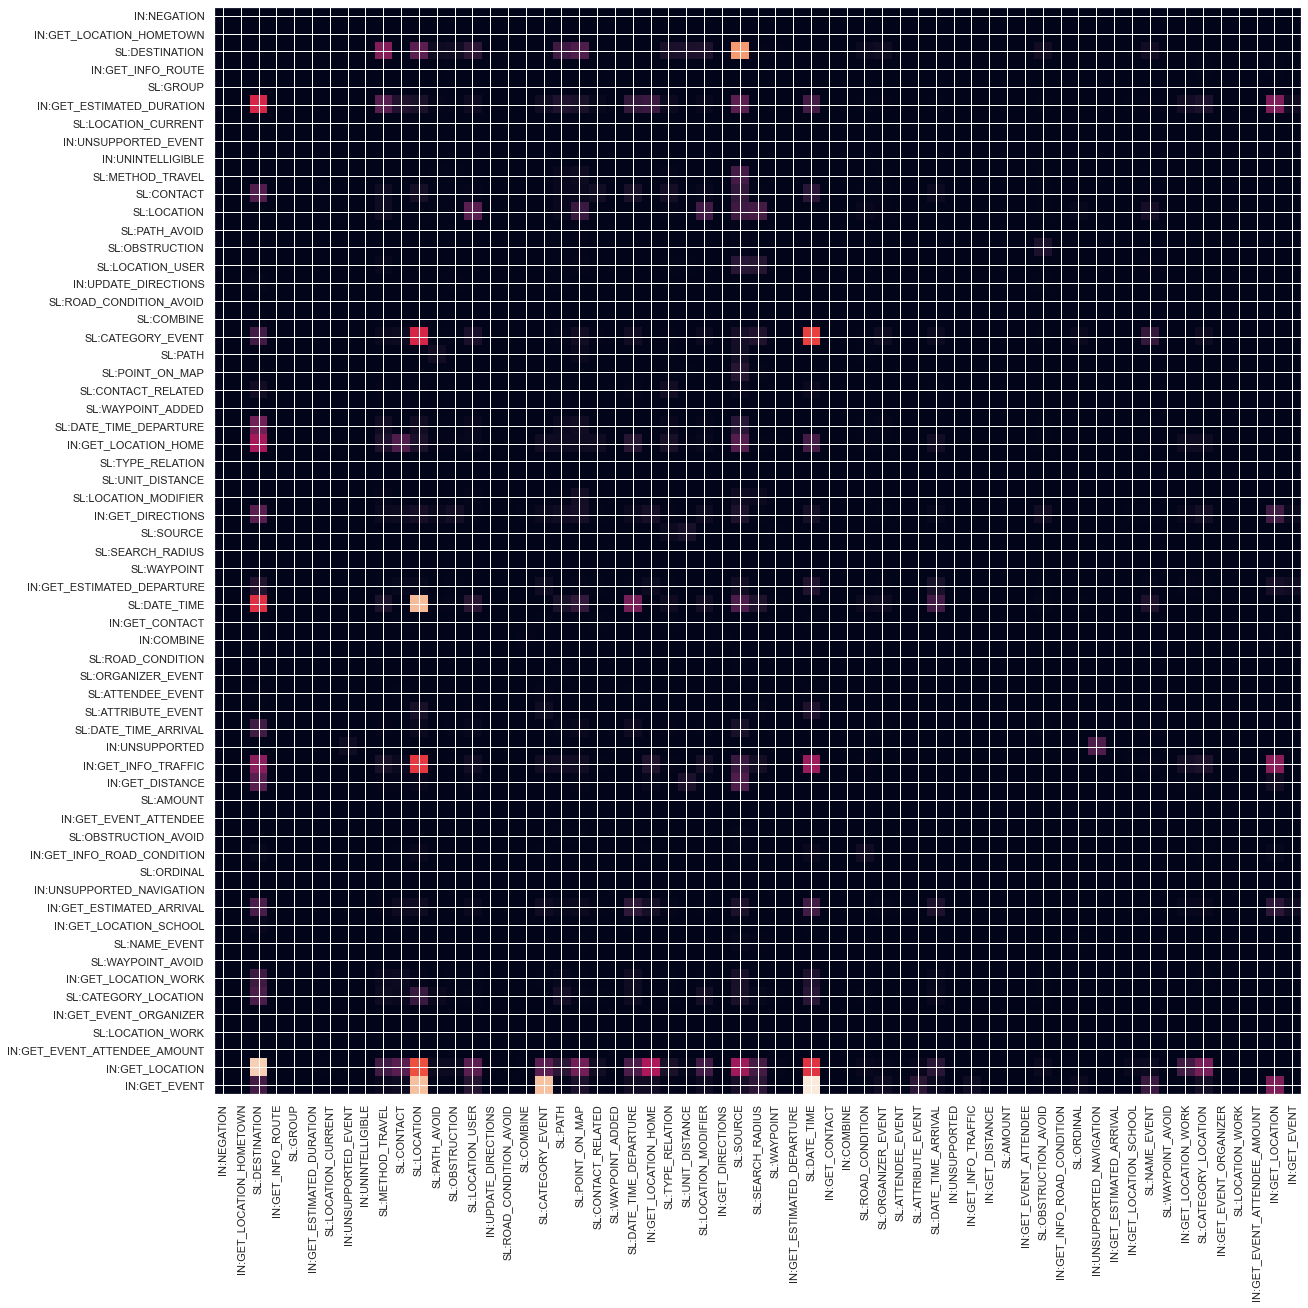

In [26]:
heatmap = np.zeros([len(vocab), len(vocab)])

itos = list(vocab)
stoi = {w: i for i, w in enumerate(itos)}

for (w1, w2), count in mutual_frequencies.items():
    heatmap[stoi[w1], stoi[w2]] = count
    
plt.figure(figsize=(20,20))
plt.xticks(list(range(len(itos))), itos, rotation='vertical')
plt.yticks(list(range(len(itos))), itos, rotation='horizontal')
plt.imshow(heatmap)